In [1]:
%load_ext autoreload
%autoreload 2
# this only works on startup!
from jax import config
config.update("jax_enable_x64", True)

import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"] = '2'
from encoding_information.gpu_utils import limit_gpu_memory_growth
limit_gpu_memory_growth()

from cleanplots import *
from tqdm import tqdm
from encoding_information.information_estimation import *
from encoding_information.image_utils import *
from encoding_information.datasets.bsccm_utils import *
from bsccm import BSCCM
from jax import jit
import numpy as onp
import jax.numpy as np

bsccm = BSCCM('/home/hpinkard_waller/data/BSCCM/')

2024-10-12 08:42:33.576598: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-12 08:42:34.368334: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2024-10-12 08:42:34.368425: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2024-10-12 08:42:34.368436: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


Opening BSCCM
Opened BSCCM


In [2]:
channel_name = 'LED119'
num_images = 1000
num_patches = 1000
patch_size = 15
edge_crop = 24

images = load_bsccm_images(bsccm, channel_name, num_images=num_images,
                            edge_crop=edge_crop, convert_units_to_photons=True, median_filter=False, verbose=False, batch=1)
patches = extract_patches(images, patch_size=patch_size, num_patches=num_patches, verbose=False)

noisy_patches = add_shot_noise_to_experimenal_data(patches, 0.2)



In [3]:
# channel_names = ['Brightfield', 'DPC_Right', 'LED119' ]
# edge_crop = 32
# num_images = 5000
# num_patches = 5000
# photons_per_pixel = 50
# num_bootstrap_samples = 1
# confidence_interval = 99
# patch_size = 30

# mi_means = []
# mi_confidences = []
# h_y_given_x_means = []
# h_y_given_x_confidences = []
# for channel_name in tqdm(channel_names):
#     images = load_bsccm_images(bsccm, channel_name, num_images=num_images, edge_crop=edge_crop, convert_units_to_photons=True, median_filter=False, verbose=False, batch=1)
#     patches = extract_patches(images, patch_size=patch_size, num_patches=num_patches, verbose=False)
#     # patches = patches * photons_per_pixel / np.mean(images)
#     # noisy_patches = add_noise(patches)

#     rescale_fraction = photons_per_pixel / np.mean(images)
#     noisy_patches = add_shot_noise_to_experimenal_data(patches, photon_fraction=rescale_fraction)

#     mi_mean, mi_confidence = run_bootstrap(noisy_patches, num_bootstrap_samples=num_bootstrap_samples, confidence_interval=confidence_interval, 
#                 estimation_fn=lambda noisy_images: estimate_mutual_information(noisy_images=noisy_images, verbose=False), verbose=True)
    
#     h_y_given_x_mean, h_y_given_x_confidence = run_bootstrap(noisy_patches, num_bootstrap_samples=num_bootstrap_samples, confidence_interval=confidence_interval,
#                 estimation_fn=lambda noisy_images: estimate_conditional_entropy(noisy_images), verbose=True)

#     mi_means.append(mi_mean)
#     mi_confidences.append(mi_confidence)
#     h_y_given_x_means.append(h_y_given_x_mean)
#     h_y_given_x_confidences.append(h_y_given_x_confidence)

    
# mi_means = np.array(mi_means)
# mi_confidences = np.array(mi_confidences)
# h_y_given_x_means = np.array(h_y_given_x_means)
# h_y_given_x_confidences = np.array(h_y_given_x_confidences)

In [4]:
# # set the width of the bars
# bar_width = 0.35
# error_kw = {'capsize': 12, 'capthick': 2}

# # create a paired bar plot of results
# fig, ax = plt.subplots(1, 1, figsize=(4, 4))


# # create the bar plots
# bar_width = 0.5
# lower_errors = mi_means - mi_confidences[:, 0]
# upper_errors = mi_confidences[:, 1] - mi_means

# # Calculate the positions where the bars should be placed to be centered on the ticks
# positions = np.arange(len(channel_names)) + 0.5 * bar_width

# ax.bar(
#     positions,
#     mi_means,
#     yerr=np.array([lower_errors, upper_errors]),
#     width=bar_width,
#     color=colors[0],
#     edgecolor='k',
#     linewidth=1,
#     error_kw=error_kw
# )

# # add labels, title, and legend
# ax.set_xticks(np.arange(len(channel_names)) + bar_width / 2, channel_names)
# ax.set_ylabel('Estimated mutual information per pixel (bits)')
# fig.suptitle(f'{confidence_interval}% confidence interval')
# clear_spines(ax)

# # make another plot for conditional entropy
# fig, ax = plt.subplots(1, 1, figsize=(4, 4))

# lower_errors = h_y_given_x_means - h_y_given_x_confidences[:, 0]
# upper_errors = h_y_given_x_confidences[:, 1] - h_y_given_x_means

# ax.bar(
#     positions,
#     h_y_given_x_means,
#     yerr=np.array([lower_errors, upper_errors]),
#     width=bar_width,
#     color=colors[0],
#     edgecolor='k',
#     linewidth=1,
#     error_kw=error_kw
# )

# # add labels, title, and legend
# ax.set_xticks(np.arange(len(channel_names)) + bar_width / 2, channel_names)
# ax.set_ylabel('Estimated conditional entropy per pixel (bits)')
# fig.suptitle(f'{confidence_interval}% confidence interval')
# clear_spines(ax)

## MI vs num photons

In [5]:
from encoding_information.models import PixelCNN, PoissonNoiseModel
from encoding_information import estimate_information

channel_names = ['Brightfield', 'DPC_Right', 'LED119' ]
edge_crop = 32
num_images = 5000
num_patches = 5000
photons_per_pixel = [30, 60, 120, 240, 480]
confidence = .95
patch_size = 10
test_fraction = 0.1
num_replicates = 5

mi_means_by_channel_photons = {}
mi_confidences_by_channel_photons = {}
for channel_name in tqdm(channel_names):
    mi_means_by_channel_photons[channel_name] = []
    mi_confidences_by_channel_photons[channel_name] = []
    images = load_bsccm_images(bsccm, channel_name, num_images=num_images, edge_crop=edge_crop, convert_units_to_photons=True, median_filter=False, verbose=False)
    for num_photons in photons_per_pixel:
        patches = extract_patches(images, patch_size=patch_size, num_patches=num_patches, verbose=False)
        noisy_patches = add_shot_noise_to_experimenal_data(patches, num_photons / np.mean(images))
        
        train_patches = noisy_patches[:int(len(noisy_patches) * (1 - test_fraction))]
        test_patches = noisy_patches[int(len(noisy_patches) * (1 - test_fraction)):]


        pixelcnn = PixelCNN()
        pixelcnn.fit(noisy_patches, verbose=False)
        noise_model = PoissonNoiseModel()
        estimate, lower, upper = estimate_information(pixelcnn, noise_model, train_patches, test_patches, confidence_interval=confidence)

        for replicate in range(1, num_replicates):
            pixelcnn = PixelCNN()
            pixelcnn.fit(noisy_patches, verbose=False)
            noise_model = PoissonNoiseModel()
            estimate_, lower_, upper_ = estimate_information(pixelcnn, noise_model, train_patches, test_patches, confidence_interval=confidence)
            if estimate_ < estimate:
                estimate = estimate_
                lower = lower_
                upper = upper_

        mi_means_by_channel_photons[channel_name].append(estimate)
        mi_confidences_by_channel_photons[channel_name].append((lower, upper))
    
mi_means_by_channel_photons = {channel: np.array(v) for channel, v in mi_means_by_channel_photons.items()}
mi_confidences_by_channel_photons = {channel: np.array(v) for channel, v in mi_confidences_by_channel_photons.items()}

  0%|                                                   | 0/3 [00:00<?, ?it/s]2024-10-12 08:44:13.250705: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:42] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.

training:  20%|██████                        | 40/200 [01:34<06:17,  2.36s/it]

Evaluating NLL: 0it [00:00, ?it/s]
Evaluating NLL: 1it [00:01,  1.99s/it]
Evaluating NLL: 16it [00:05,  2.89it/s]

Evaluating NLL: 0it [00:00, ?it/s]
Evaluating NLL: 1it [00:02,  2.71s/it]
Evaluating NLL: 37it [00:02, 18.36it/s]
Evaluating NLL: 67it [00:02, 37.13it/s]
Evaluating NLL: 106it [00:03, 67.80it/s]
Evaluating NLL: 147it [00:03, 105.29it/s]
Evaluating NLL: 181it [00:03, 132.01it/s]
Evaluating NLL: 213it [00:03, 156.87it/s]
Evaluating NLL: 243it [00:03, 179.17it/s]
Evaluating NLL: 274it [00:03, 205.13it/s]
Evaluating NLL: 304it [00:03, 216.72it/s]
Evaluating NLL: 333it [00:03, 230.11it/s]
Evaluating NLL: 361it

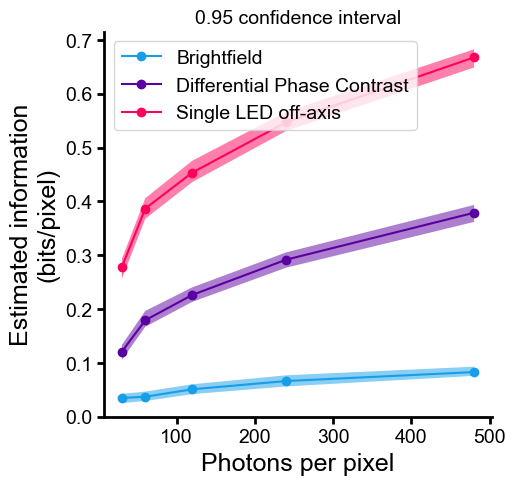

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.plot(photons_per_pixel, mi_means_by_channel_photons['Brightfield'], '-o',
         label=get_display_channel_names('Brightfield'))
ax.fill_between(photons_per_pixel, mi_confidences_by_channel_photons['Brightfield'][:, 0], 
                mi_confidences_by_channel_photons['Brightfield'][:, 1], alpha=0.5)
ax.plot(photons_per_pixel, mi_means_by_channel_photons['DPC_Right'], '-o',
        label=get_display_channel_names('DPC_Right'))
ax.fill_between(photons_per_pixel, mi_confidences_by_channel_photons['DPC_Right'][:, 0],
                 mi_confidences_by_channel_photons['DPC_Right'][:, 1], alpha=0.5)
ax.plot(photons_per_pixel, mi_means_by_channel_photons['LED119'], '-o',
        label=get_display_channel_names('LED119'))
ax.fill_between(photons_per_pixel, mi_confidences_by_channel_photons['LED119'][:, 0], 
                mi_confidences_by_channel_photons['LED119'][:, 1], alpha=0.5)
ax.set(xlabel='Photons per pixel', ylabel='Estimated information\n(bits/pixel)', ylim=[0, None])
ax.legend()
clear_spines(ax)
ax.title.set_text(f'{confidence} confidence interval')

fig.savefig('/home/hpinkard_waller/figures/mi_estimation/' + 'mi_vs_photon_count_' + '.pdf', transparent=True)

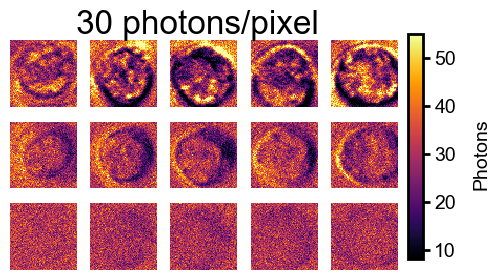

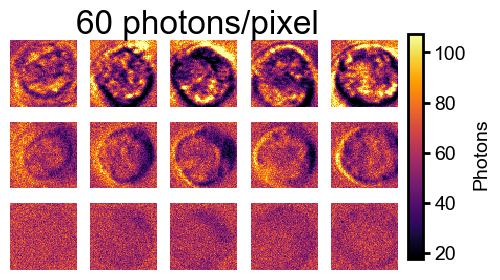

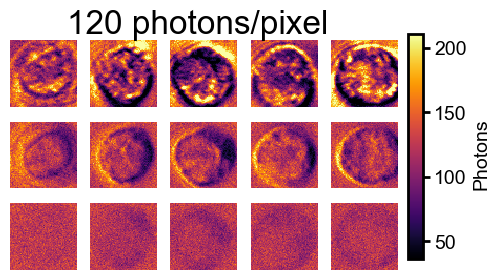

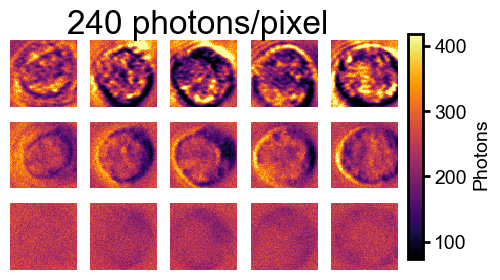

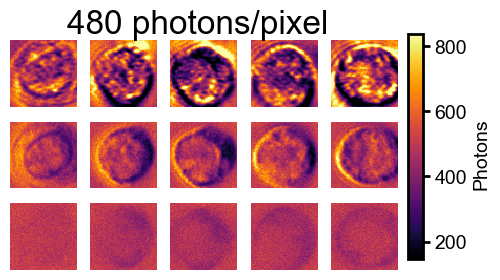

In [7]:
# show representative images for each channel at each photon level 
num_images = 5

for photons in photons_per_pixel:
    fig, axes = plt.subplots(3, num_images, figsize=(num_images, 3))
    vmin, vmax = None, None
    for channel_idx, channel_name in enumerate(channel_names[::-1]):
        images = load_bsccm_images(bsccm, channel_name, num_images=5, edge_crop=edge_crop, convert_units_to_photons=True, median_filter=False, verbose=False)
        noisy_images = add_shot_noise_to_experimenal_data(images, photons / np.mean(images))
        if vmin is None:
            vmin, vmax = np.percentile(noisy_images, 3), np.percentile(noisy_images, 97)
        for i in range(num_images):
            im = axes[channel_idx, i].imshow(noisy_images[i], cmap='inferno', interpolation='none', vmin=vmin, vmax=vmax)
            axes[channel_idx, i].axis('off')
    fig.suptitle(f'{photons} photons/pixel')

    # add colorbar
    cbar_ax = fig.add_axes([0.92, 0.15, 0.03, 0.75])
    fig.colorbar(im, cax=cbar_ax)
    # add photons label
    fig.text(1.05, 0.5, 'Photons', va='center', rotation='vertical')
    fig.savefig('/home/hpinkard_waller/figures/mi_estimation/' + f'images_photons_{photons}.pdf', transparent=True)

    